<a href="https://colab.research.google.com/github/AnLiMan/Potato-Disease-Leaf-Recognazing/blob/main/Potato_Disease_Leaf_Recognazing_v_0_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Инструкция по работе

by AnLi

#Результаты тестов
Датасет включает в себя 
- 1 Итерация. loss: 0.1458 - accuracy: 0.9548 - val_loss: 0.3871 - val_accuracy: 0.8850

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (2,2), activation='relu', input_shape=(256, 256, 3)),tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

- 2 Итерация. loss: 0.1498 - accuracy: 0.9657 - val_loss: 0.0332 - val_accuracy: 0.9823
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (2,2), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

- 3 Итерация.


#Подключение библиотек, гугл диска и определение текущего номера итерации

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
number_of_interations = 2
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Mounted at /content/drive
Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  2


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from __future__ import absolute_import, division, print_function, unicode_literals
import time

!pip install -q pyyaml h5py  # Требуется для сохранения модели в формате HDF5
zip_file = '/content/drive/My Drive/Files for colab/CNN for Potato/Potato-Leaf.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir)

<built-in function listdir>


#Определение данных для тестирования и создание архитектуры нейросети

In [ ]:
#перед этим создайте папку с данными train и в папке train создайте еще шесть папок для шести дефектов
import shutil
import numpy as np

try:
    source1 = "Potato-Leaf/train"
    os.mkdir("Potato-Leaf/test")
    dest11 = "Potato-Leaf/test"
    files = os.listdir(source1)

    for f in files:
        os.mkdir(dest11 + '/'+ f)
        spilt_num = int(len(os.listdir(source1 + '/'+ f))*0.08)
        for i in os.listdir(source1 + '/'+ f)[spilt_num:]:
            shutil.move(source1 + '/'+ f +'/'+ i, dest11 + '/'+ f +'/'+ i)
except:
    print("\nВсе уже есть в каталоге. Вам не нужно запускать эту ячейку")


Все уже есть в каталоге. Вам не нужно запускать эту ячейку


## Разделение тестовой и тренировочных выборок

In [ ]:
import shutil
import numpy as np

try:
    source1 = "Potato-Leaf/test"
    os.mkdir("Potato-Leaf/valid")
    dest11 = "Potato-Leaf/valid"
    files = os.listdir(source1)

    for f in files:
        os.mkdir(dest11 + '/'+ f)
        spilt_num=int(len(os.listdir(source1 + '/'+ f))*0.5)
        for i in os.listdir(source1 + '/'+ f)[spilt_num:]:
            shutil.move(source1 + '/'+ f +'/'+ i, dest11 + '/'+ f +'/'+ i)
except:
    print("\nВсе уже есть в каталоге. Вам не нужно запускать эту ячейку")

##Определение архитектуры нейросети

Метод batch сообщает методу тренировки model.fit использовать блоки по 10 изображений и метки при обновлении внутренних переменных модели.

In [ ]:
# Все изображения будут смасштабированы к 1./255
train_datagen = ImageDataGenerator(rescale = 1. / 255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Обучающие изображения партиями по 10 с использованием генератора train_datagen
train_generator = train_datagen.flow_from_directory('Potato-Leaf/train', target_size = (256, 256), batch_size = 10, class_mode = 'categorical')

# Тестовая выборка по 10 пакетов с использованием генератора train_datagen
validation_generator = test_datagen.flow_from_directory('Potato-Leaf/valid', target_size = (256, 256), batch_size = 10, class_mode = 'categorical')

Found 1835 images belonging to 3 classes.
Found 113 images belonging to 3 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.93 ):
            print("\nТочность расчёта более 93%, расчёт был остановлен!")
            self.model.stop_training = True 

Процесс преобразования 2D-изображения в вектор называется сглаживанием (flattening) и реализуется посредством сглаживающего слоя — flatten-слоя.

ReLU — функция активации нейрона. Функция ReLU возвращает 0, если в качестве входного значения было отрицательное значение или ноль, во всех остальных случаях функция вернёт исходное входное значение.

Softmax — функция, которая вычисляет вероятности для каждого возможного выходного класса;


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (2,2), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
print('Модель свёрточной сети создана')
model.summary()

Модель свёрточной сети создана
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPool

# Обучение нейросети

In [ ]:
callbacks = myCallback()
checkpoint_path = "/content/drive/My Drive/Files for colab/CNN for Potato/Checkpoint_" + str(number_of_interations) + ".ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Создаем коллбек сохраняющий веса модели
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)
history = model.fit(train_generator, batch_size = 20, epochs = 15, validation_data = validation_generator, callbacks=[cp_callback], verbose = 1, shuffle = True)
# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/CNN for Potato/Potato_model_" + str(number_of_interations) + ".h5")

Epoch 1/15
184/184 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.7335
Epoch 1: saving model to /content/drive/My Drive/Files for colab/CNN for Potato/Checkpoint_2.ckpt
184/184 [==============================] - 110s 593ms/step - loss: 0.7387 - accuracy: 0.7335 - val_loss: 0.3815 - val_accuracy: 0.8938
Epoch 2/15
184/184 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8556
Epoch 2: saving model to /content/drive/My Drive/Files for colab/CNN for Potato/Checkpoint_2.ckpt
184/184 [==============================] - 108s 585ms/step - loss: 0.3573 - accuracy: 0.8556 - val_loss: 0.1706 - val_accuracy: 0.9469
Epoch 3/15
184/184 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.9204
Epoch 3: saving model to /content/drive/My Drive/Files for colab/CNN for Potato/Checkpoint_2.ckpt
184/184 [==============================] - 112s 599ms/step - loss: 0.2503 - accuracy: 0.9204 - val_loss: 0.5147 - val_accuracy: 0.8496
Epoch 4/15
18

Графики результатов обучения

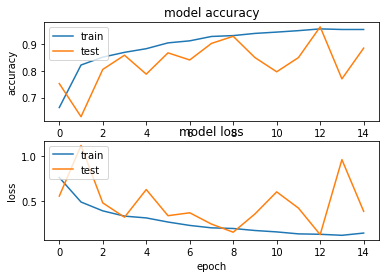

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  

# обобщение истории для точности   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # обобщение истории для потерь    
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

#Загрузка и работа с обученной моделью

In [ ]:
# Восстановим в точности ту же модель, включая веса и оптимизатор
Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/CNN for Potato/Potato_model_" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0

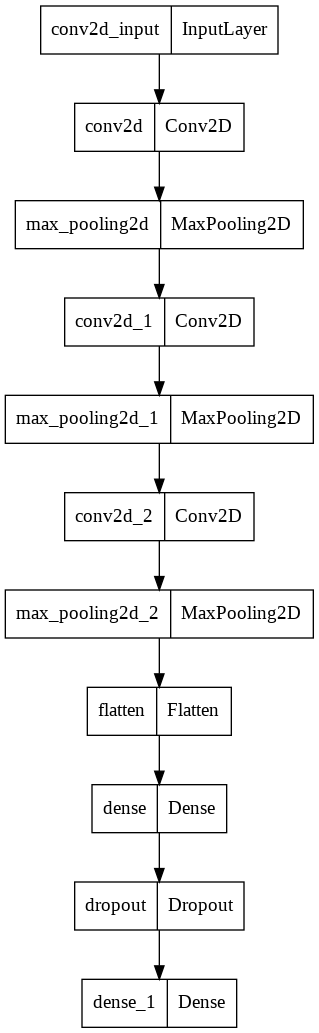

In [ ]:
keras.utils.plot_model(Loading_model, 'Model.png')

In [ ]:
# Загрузим имена файлов и их соответствующие целевые метки в массив numpy
from sklearn.datasets import load_files
import numpy as np

test_dir = 'Potato-Leaf/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
print('Количество классов: ', no_of_classes)

Количество классов:  3


In [ ]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [ ]:
# У нас есть только имена файлов в наборе x. Загрузим изображения и преобразуем их в массив.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Преобразование в массив Numpy
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Размеры тестовой выборки (кол-во изображений, размеры, кол-во каналов): ', x_test.shape)

Размеры тестовой выборки (кол-во изображений, размеры, кол-во каналов):  (113, 256, 256, 3)


In [ ]:
x_test = x_test.astype('float32')/255

##Визуализация предсказаний

Время выполнения операции =  0.21859002113342285  c


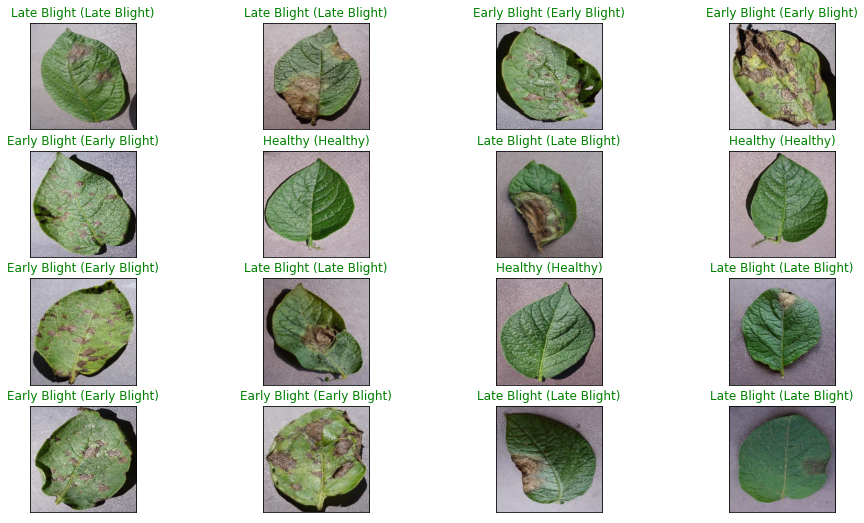

In [ ]:
import matplotlib.pyplot as plt

y_pred = Loading_model.predict(x_test)
start_time = time.time()
# построение случайной выборки тестовых изображений, их предсказанные метки и  истинного значения
fig = plt.figure(figsize = (16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 16, replace = False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color = ("green" if pred_idx == true_idx else "red"))

print("Время выполнения операции = ", (time.time() - start_time), ' c')

Тест программы

Введите номер изображения, для теста из тестовой выборки (от 0 до 112)
56
Время выполнения операции =  0.10570144653320312  c


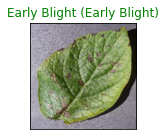

In [ ]:
import matplotlib.pyplot as plt

print('Введите номер изображения, для теста из тестовой выборки (от 0 до 112)')
idx = int(input())

start_time = time.time()
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
ax.imshow(np.squeeze(x_test[idx]))
pred_idx = np.argmax(y_pred[idx])
true_idx = np.argmax(y_test[idx])
ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))
print("Время выполнения операции = ", (time.time() - start_time), ' c')

##Прогон всей тестовой выборки

In [ ]:
import matplotlib.pyplot as plt

print('Прогон всех тестовых изображений по порядку')

for k in range(113):

  fig = plt.figure(figsize=(16, 9))
  ax = fig.add_subplot(4, 4, 2, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_test[k]))
  pred_idx = np.argmax(y_pred[k])
  true_idx = np.argmax(y_test[k])
  ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))

##Уберём визуализирующую состовляющую, чтобы вычислить время, требующееся для расчёта одного изображения

In [ ]:
print('Введите номер изображения, для теста из тестовой выборки (от 0 до 112)')
idx = int(input())

start_time = time.time()
pred_idx = np.argmax(y_pred[idx])
print('Номер дефекта: ', pred_idx)
print("Время выполнения операции = ", (time.time() - start_time), ' c')
time_for_operation = (time.time() - start_time)
print("Расшифровка: Early Blight = 0, Healty = 1, Late Blight = 2")

Введите номер изображения, для теста из тестовой выборки (от 0 до 112)
56
Номер дефекта:  0
Время выполнения операции =  0.0007908344268798828  c
Расшифровка: Early Blight = 0, Healty = 1, Late Blight = 2
